In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MinMaxScaler
import h5py
import gc

##  Lorenz'96 Testcase:

The reference model is a two-level system of ODEs for $K$ large-scale
variables, each with $J$ small-scale components. The evolution equations for
large- and small-scale components ($X_k$s and $Y_j$s, respectively) are given as,

<h3>$\dfrac{dX_k}{dt} = -X_{k-1}(X_{k-2} - X_{k+1}) - X_k + F - hc\overline{Y}_k$ </h3>
<h3>$\dfrac{1}{c}\dfrac{dY_{j,k}}{dt} = -b Y_{j+1,k}(Y_{j+2,k} - Y_{j-1,k}) - Y_{j,k} + \dfrac{h}{J}X_k $</h3>

Here $h$ is the coupling constant, $c$ is the temporal scale ratio, and $b$ is the spatial scale ratio. The imperfect model is the set of equations corresponding to the large-scale
components only, i.e.,
<h3>$\dfrac{dX_j}{dt} = -X_{k-1}(X_{k-2} - X_{k+1}) - X_k + F $ </h3>

Typical values of the involved parameters are: $K=36$, $J=10$, $h=1$, $F=10$, $c=10$, and $b=10$.   

In [2]:
def L96_twolevel(y,t,K=36,J=10,h=1,F=10,c=10,b=10):
    X = y[:K]
    Y = y[K:].reshape((J,K))
    dydt = np.zeros(y.shape)
    dydt[:K] = - np.roll(X,-1)*(np.roll(X,-2)-np.roll(X,1)) - X -(h*c)*np.mean(Y,axis=0) + F
    dydt[K:] = -c*(b*np.roll(Y,(1,0))*(np.roll(Y,(2,0))-np.roll(Y,(-1,0))) + Y - (h/J)*np.tile(X,(J,1))).reshape(K*J)
    return list(dydt)

In [3]:
def L96_onelevel(y,t,F=10):
    dydt = -np.roll(y,-1)*(np.roll(y,-2)-np.roll(y,1)) - y + F
    return list(dydt)

In [4]:
# params
K = 8; J = 4; F = 10
h = 1; c = 10; b = 10 # default: b=10
t0 = 0
tend = t0+1000
dt = 0.1
nt = int((tend-t0)/dt)
t = np.linspace(t0,tend,nt+1)

# initialization
np.random.seed(10)
Xinit = np.random.normal(0.25*F,0.5*F,K) # resolved

np.random.seed(20)
ss_init = np.random.normal(0,1,J*K) # unresolved
Yinit = np.append(Xinit, ss_init) # resolved + unresolved

# integrate the Lorenz models over t
# Perfect Model
args_twolevel = (K,J,h,F,c,b)
states_twolevel = odeint(L96_twolevel,Yinit,t,args=args_twolevel)

# Imperfect Model
# Here the imperfections are due to (1) the absence of small-scales, and
# (2) error in the forcing term
F_imp = 3
args_onelevel = (F_imp,)
states_onelevel = odeint(L96_onelevel,Xinit,t,args=args_onelevel)

# define the physical location of CATs and the test dataset 
cats_path = './trained_cats/'
ntest = int(0.8*nt) # length of the test data
testdat_ref = states_twolevel[ntest:,:]
testdat_mod = states_onelevel[ntest:,:]

# lead times used in this analysis
tau_arr = np.linspace(0.1,1,10)

## Linear-Regression-based parameterization for small scales

Slope: 0.05280856022228611
Intercept: -0.007883581875466728


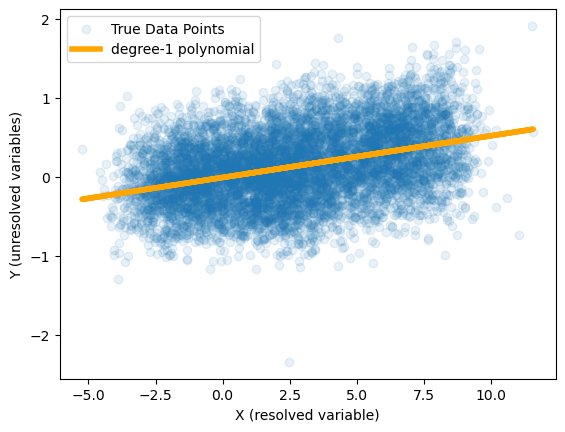

In [5]:
# degree 1 polynomial
slope, intercept = np.polyfit(states_twolevel[:ntest,:K].ravel(), states_twolevel[:ntest,K:2*K].ravel(), 1)
p_deg1 = np.poly1d([slope, intercept]) # create a 1d polynomial object
print('Slope:',slope)
print('Intercept:',intercept)


fig, ax = plt.subplots()
ax.scatter(states_twolevel[:1000,:K].ravel(), states_twolevel[:1000,K:2*K].ravel(), 
           alpha=0.1, label='True Data Points')
ax.plot(states_twolevel[:1000,:K].ravel(), p_deg1(states_twolevel[:1000,:K].ravel()),
        color='orange', lw=4, label='degree-1 polynomial')

plt.xlabel('X (resolved variable)'); plt.ylabel('Y (unresolved variables)')
ax.legend()
plt.show()

## Read the HDF5 weight files

In [6]:
def read_hdf5(path):

    weights = {}
    
    keys = []
    with h5py.File(path, 'r') as f: # open file
        f.visit(keys.append) # append all keys to list
        print(keys)
        c = 0
        for key in keys:
            if ':' in key: # contains data if ':' in key
                print(f[key].name)
                if 'bias' in key:
                    weights['bias'+str(c)] = f[key][()]
                else:
                    weights['kernel'+str(c)] = f[key][()]
                    c = c + 1
    return weights

# test the function
if __name__ == '__main__':
    filename = cats_path + 'L96_trm_tau=0.5.h5'
    weights = read_hdf5(filename)

['add_8', 'dense_16', 'dense_16/dense_16', 'dense_16/dense_16/bias:0', 'dense_16/dense_16/kernel:0', 'dense_17', 'dense_17/dense_17', 'dense_17/dense_17/bias:0', 'dense_17/dense_17/kernel:0', 'input_13', 'tf.__operators__.getitem_4', 'top_level_model_weights']
/dense_16/dense_16/bias:0
/dense_16/dense_16/kernel:0
/dense_17/dense_17/bias:0
/dense_17/dense_17/kernel:0


## Define the normalization as used in training CATs

In [8]:
normalization = 'standard'

if normalization=='standard':
    scaler_ref = StandardScaler()
    scaler_ref.fit(states_twolevel)
    scaler_model = StandardScaler()
    scaler_model.fit(states_onelevel)

elif normalization=='min-max':
    scaler_ref = MinMaxScaler()
    scaler_ref.fit(states_twolevel)
    scaler_model = MinMaxScaler()
    scaler_model.fit(states_onelevel)

else:
    ValueError('Normalization type not recognised')

### Define LR-based parameterization for the normalized data

In [10]:
states_twolevel_norm = scaler_ref.transform(states_twolevel)
slope_norm, intercept_norm = np.polyfit(states_twolevel_norm[:ntest,:K].ravel(), 
                                        states_twolevel_norm[:ntest,K:2*K].ravel(), 1)
p_deg1_norm = np.poly1d([slope_norm, intercept_norm]) # create a 1d polynomial object
print('slope:',slope_norm)
print('intercept:',intercept_norm)

slope: 0.3750264927511361
intercept: -0.0005011650991306945


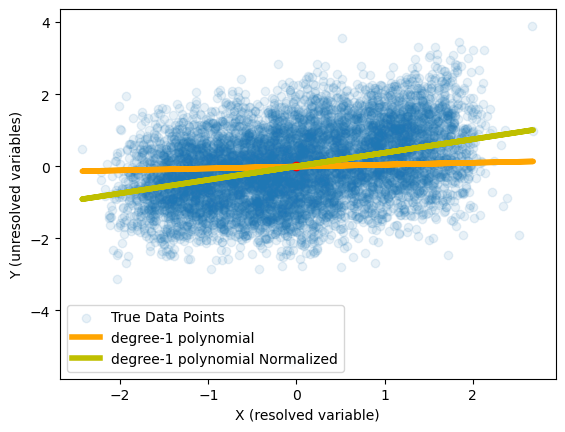

In [12]:
fig, ax = plt.subplots()
ax.scatter(states_twolevel_norm[:1000,:K].ravel(), states_twolevel_norm[:1000,K:2*K].ravel(), 
           alpha=0.1, label='True Data Points')
ax.plot(states_twolevel_norm[:1000,:K].ravel(), p_deg1(states_twolevel_norm[:1000,:K].ravel()),
        color='orange', lw=4, label='degree-1 polynomial')
ax.plot(states_twolevel_norm[:1000,:K].ravel(), p_deg1_norm(states_twolevel_norm[:1000,:K].ravel()),
        color='y', lw=4, label='degree-1 polynomial Normalized')
ax.scatter(0,0,color='r',marker='o')

plt.xlabel('X (resolved variable)'); plt.ylabel('Y (unresolved variables)')
ax.legend()
plt.show()

## Case I : Consider a random blob of states in the ref space and apply $T_{rm}$ from various $\tau$

<IPython.core.display.Javascript object>


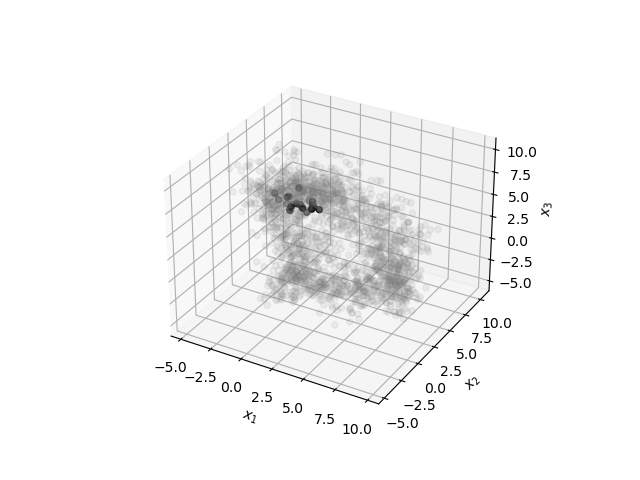

In [8]:
%matplotlib notebook
# number of nearest neighbours 
nn = 20

# draw a random state
index = np.random.randint(0,np.shape(testdat_ref)[0])
state_ref = testdat_ref[index,:]

# get the nearest neighbours
nn_dist = np.sqrt(np.mean((states_twolevel - state_ref)**2, axis=1))
nn_indices = np.argsort(nn_dist)[:nn]
blob_ref = states_twolevel[np.sort(nn_indices),:] # blob of points in the reference space
    
# plot
fig, ax = plt.subplots(1,1,subplot_kw=dict(projection="3d"))
ax.scatter(states_twolevel[-2000:,0],states_twolevel[-2000:,1],
           states_twolevel[-2000:,2], color='grey', alpha=0.1)
ax.scatter(blob_ref[:,0],blob_ref[:,1],blob_ref[:,2],color='k')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$x_3$')
plt.show()

### Project the blob to the model phase space

In [9]:
# project the blob to the model space using T_rm trained for various taus
blob_mod = np.zeros((len(tau_arr),nn,K))
blob_ref_norm = scaler_ref.transform(blob_ref)

blob_mod_lin_cats_norm = blob_ref_norm[:,:K]

for i,tau in zip(range(len(tau_arr)),tau_arr):
    filename = cats_path + f'L96_trm_tau={tau:.1f}.h5'
    weights = read_hdf5(filename)
    
    # project blob_ref
    temp = np.tanh(blob_ref_norm@weights['kernel0'] + np.tile(weights['bias0'].reshape(1,-1),[nn,1]) )
    blob_mod_norm = np.tanh(temp@weights['kernel1'] + np.tile(weights['bias1'].reshape(1,-1),[nn,1]) )
    blob_mod[i,:,:] = scaler_model.inverse_transform(blob_mod_norm+blob_mod_lin_cats_norm)

['add', 'dense', 'dense/dense', 'dense/dense/bias:0', 'dense/dense/kernel:0', 'dense_1', 'dense_1/dense_1', 'dense_1/dense_1/bias:0', 'dense_1/dense_1/kernel:0', 'input_1', 'tf.__operators__.getitem', 'top_level_model_weights']
/dense/dense/bias:0
/dense/dense/kernel:0
/dense_1/dense_1/bias:0
/dense_1/dense_1/kernel:0
['add_2', 'dense_4', 'dense_4/dense_4', 'dense_4/dense_4/bias:0', 'dense_4/dense_4/kernel:0', 'dense_5', 'dense_5/dense_5', 'dense_5/dense_5/bias:0', 'dense_5/dense_5/kernel:0', 'input_4', 'tf.__operators__.getitem_1', 'top_level_model_weights']
/dense_4/dense_4/bias:0
/dense_4/dense_4/kernel:0
/dense_5/dense_5/bias:0
/dense_5/dense_5/kernel:0
['add_4', 'dense_8', 'dense_8/dense_8', 'dense_8/dense_8/bias:0', 'dense_8/dense_8/kernel:0', 'dense_9', 'dense_9/dense_9', 'dense_9/dense_9/bias:0', 'dense_9/dense_9/kernel:0', 'input_7', 'tf.__operators__.getitem_2', 'top_level_model_weights']
/dense_8/dense_8/bias:0
/dense_8/dense_8/kernel:0
/dense_9/dense_9/bias:0
/dense_9/dense

<IPython.core.display.Javascript object>


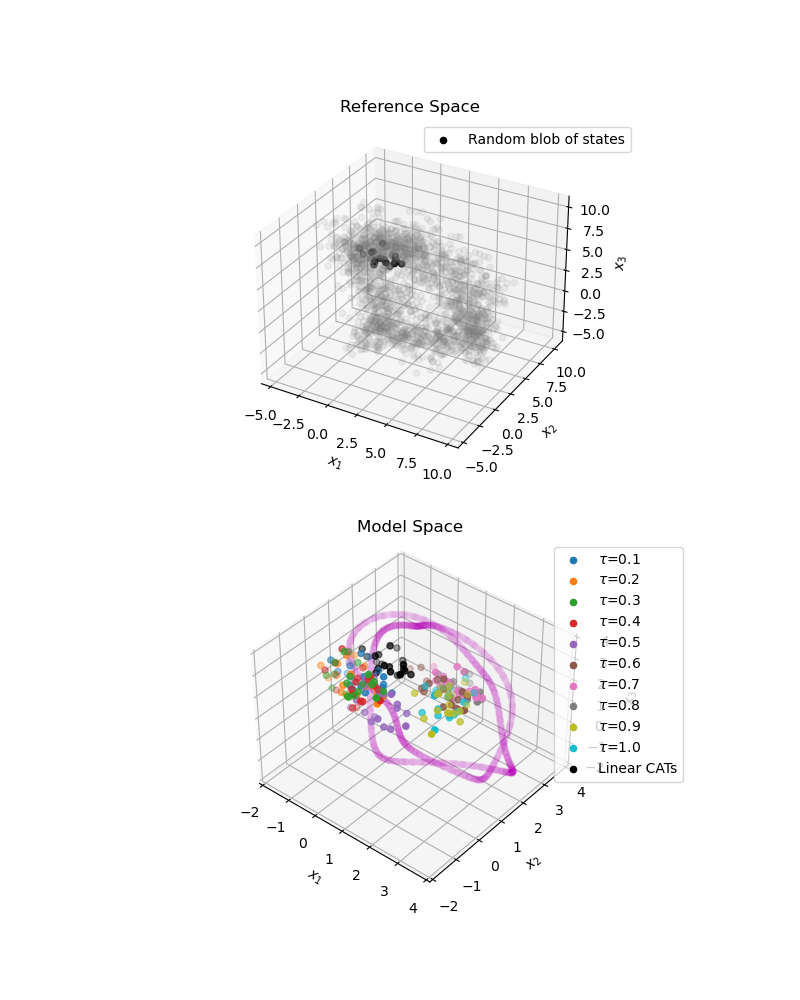

In [11]:
# Plot
import string
fig = plt.figure(figsize=(8,10))
ax1 = fig.add_subplot(2,1,1,projection="3d")

blob_mod_lin_cats = scaler_model.inverse_transform(blob_mod_lin_cats_norm)
#----------------------------------

# Reference Space
ax1.scatter(states_twolevel[-2000:,0],states_twolevel[-2000:,1],
           states_twolevel[-2000:,2],color='grey',alpha=0.1)
ax1.scatter(blob_ref[:,0],blob_ref[:,1],blob_ref[:,2],color='k',
            label='Random blob of states')
ax1.set_title('Reference Space')
#ax1.set_xlim([-4,12]); ax.set_ylim([-4,10]); ax.set_zlim([-1,10]);
ax1.set_xlabel(f'$x_1$'); ax1.set_ylabel(f'$x_2$'); ax1.set_zlabel(f'$x_3$');
#ax1.view_init(azim=-20,elev=25)
ax1.legend(bbox_to_anchor=(1.15, 1), loc='upper right')
#ax1.text(-4, -10, 20, string.ascii_uppercase[0], size=16, weight='bold')

#----------------------------------
ax2 = fig.add_subplot(2,1,2,projection="3d")
ax2.scatter(states_onelevel[-1000:,0],states_onelevel[-1000:,1],
           states_onelevel[-1000:,2],color='m',marker='o',alpha=0.05)
for i in range(10):
    ax2.scatter(blob_mod[i,:,0],blob_mod[i,:,1],blob_mod[i,:,2],
                label=r'$\tau$'+f'={tau_arr[i]:.1f}')
    
ax2.scatter(blob_mod_lin_cats[:,0],blob_mod_lin_cats[:,1],blob_mod_lin_cats[:,2],
            label=f'Linear CATs', color='k')
ax2.set_title('Model Space')
ax2.set_xlim([-2,4]); ax2.set_ylim([-2,4]); ax2.set_zlim([-2,4]);
ax2.set_xlabel(f'$x_1$'); ax2.set_ylabel(f'$x_2$'); ax2.set_zlabel(f'$x_3$');
ax2.legend(bbox_to_anchor=(1.3, 1), loc='best')
#ax2.view_init(azim=-15,elev=15)
#ax2.text(-2,-4,10,string.ascii_uppercase[1], size=16, weight='bold')
#plt.savefig(f'CATs_linear_nonlinear_blob_ICs_n_mtu={tau_arr[0]}-{tau_arr[-1]}.jpeg',dpi=400)
plt.show()

## Case II: Visualize the same for the reference state only (i.e., no NNs)

In [12]:
state_mod = np.zeros((len(tau_arr),K))
state_ref_norm = scaler_ref.transform(np.reshape(state_ref,[1,-1]))

state_mod_lin_cats_norm = state_ref_norm[:,:K]

for i,tau in zip(range(len(tau_arr)),tau_arr):
    filename = cats_path + f'L96_trm_tau={tau:.1f}.h5'
    weights = read_hdf5(filename)
    
    # project state_ref
    temp = np.tanh(state_ref_norm@weights['kernel0'] + weights['bias0'].reshape(1,-1) )
    state_mod_norm = np.tanh(temp@weights['kernel1'] + weights['bias1'].reshape(1,-1) )
    state_mod[i,:] = np.squeeze(scaler_model.inverse_transform(state_mod_norm+state_mod_lin_cats_norm))

['add', 'dense', 'dense/dense', 'dense/dense/bias:0', 'dense/dense/kernel:0', 'dense_1', 'dense_1/dense_1', 'dense_1/dense_1/bias:0', 'dense_1/dense_1/kernel:0', 'input_1', 'tf.__operators__.getitem', 'top_level_model_weights']
/dense/dense/bias:0
/dense/dense/kernel:0
/dense_1/dense_1/bias:0
/dense_1/dense_1/kernel:0
['add_2', 'dense_4', 'dense_4/dense_4', 'dense_4/dense_4/bias:0', 'dense_4/dense_4/kernel:0', 'dense_5', 'dense_5/dense_5', 'dense_5/dense_5/bias:0', 'dense_5/dense_5/kernel:0', 'input_4', 'tf.__operators__.getitem_1', 'top_level_model_weights']
/dense_4/dense_4/bias:0
/dense_4/dense_4/kernel:0
/dense_5/dense_5/bias:0
/dense_5/dense_5/kernel:0
['add_4', 'dense_8', 'dense_8/dense_8', 'dense_8/dense_8/bias:0', 'dense_8/dense_8/kernel:0', 'dense_9', 'dense_9/dense_9', 'dense_9/dense_9/bias:0', 'dense_9/dense_9/kernel:0', 'input_7', 'tf.__operators__.getitem_2', 'top_level_model_weights']
/dense_8/dense_8/bias:0
/dense_8/dense_8/kernel:0
/dense_9/dense_9/bias:0
/dense_9/dense

<IPython.core.display.Javascript object>


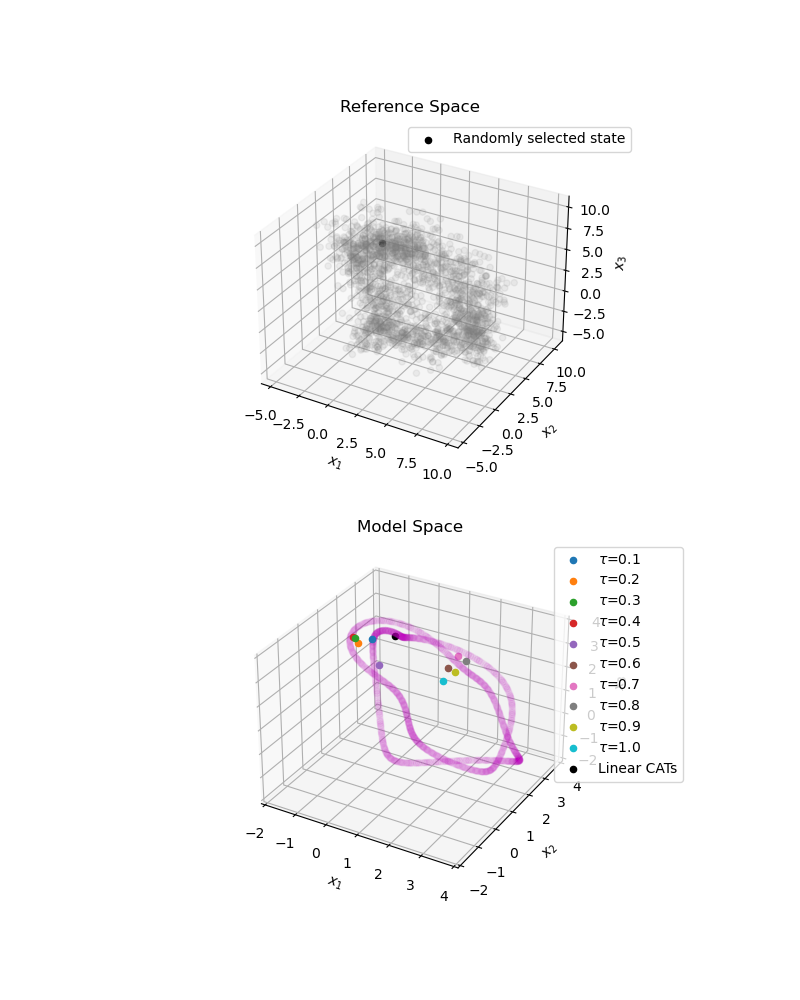

In [13]:
# Plot
fig = plt.figure(figsize=(8,10))
ax1 = fig.add_subplot(2,1,1,projection="3d")

state_mod_lin_cats = scaler_model.inverse_transform(state_mod_lin_cats_norm)
#----------------------------------

# Reference Space
ax1.scatter(states_twolevel[-2000:,0],states_twolevel[-2000:,1],
            states_twolevel[-2000:,2],color='grey',alpha=0.1)
ax1.scatter(state_ref[0],state_ref[1],state_ref[2],color='k',
            label='Randomly selected state',s=20)
ax1.set_title('Reference Space')
#ax1.set_xlim([-4,12]); ax.set_ylim([-4,10]); ax.set_zlim([-1,10]);
ax1.set_xlabel(f'$x_1$'); ax1.set_ylabel(f'$x_2$'); ax1.set_zlabel(f'$x_3$');
#ax1.view_init(azim=-20,elev=25)
ax1.legend(bbox_to_anchor=(1.15, 1), loc='upper right')
#ax1.text(-4, -10, 20, string.ascii_uppercase[0], size=16, weight='bold')

#----------------------------------

ax2 = fig.add_subplot(2,1,2,projection="3d")
ax2.scatter(states_onelevel[-1000:,0],states_onelevel[-1000:,1],
           states_onelevel[-1000:,2],color='m',marker='o',alpha=0.05)
for i in range(len(tau_arr)):
    ax2.scatter(state_mod[i,0],state_mod[i,1],state_mod[i,2],
                label=r'$\tau$'+f'={tau_arr[i]:.1f}',s=20)
    
ax2.scatter(state_mod_lin_cats[:,0],state_mod_lin_cats[:,1],state_mod_lin_cats[:,2],
            label=f'Linear CATs', color='k',s=20)
ax2.set_title('Model Space')
ax2.set_xlim([-2,4]); ax2.set_ylim([-2,4]); ax2.set_zlim([-2,4]);
ax2.set_xlabel(f'$x_1$'); ax2.set_ylabel(f'$x_2$'); ax2.set_zlabel(f'$x_3$');
ax2.legend(bbox_to_anchor=(1.3, 1), loc='best')
#ax2.view_init(azim=-15,elev=15)
#ax2.text(-2,-4,10,string.ascii_uppercase[1], size=16, weight='bold')
#plt.savefig(f'CATs_linear_nonlinear_blob_ICs_n_mtu={tau_arr[0]}-{tau_arr[-1]}.jpeg',dpi=400)
plt.show()

## Case III: Visualize for states within a ball of radius 1 

<IPython.core.display.Javascript object>


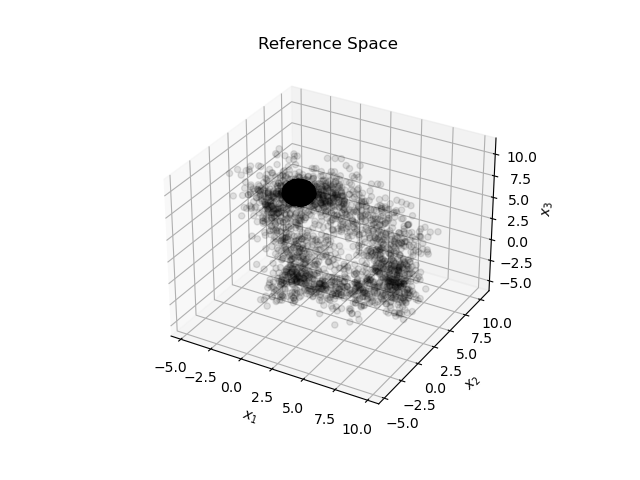

In [14]:
# Using random perturbations in X_i, i = 1,2,...,ndim
r = 1; nrand = 500; ndim = 3
rand_pert = np.random.randn(nrand,ndim)
norm = np.sqrt(np.sum(np.square(rand_pert),axis=1)).reshape(-1,1)
if (ndim < K+J*K):
    rand_pert = np.hstack([r*rand_pert/np.tile(norm,[1,ndim]),np.zeros((nrand,K*J+K-ndim))]) 
else:
    rand_pert = r*rand_pert/np.tile(norm,[1,ndim])

sphere_ref = np.tile(state_ref,[nrand,1])+rand_pert

# plot
fig, ax = plt.subplots(1,1,subplot_kw=dict(projection="3d"))
ax.scatter(states_twolevel[-2000:,0],states_twolevel[-2000:,1],
              states_twolevel[-2000:,2], color='k', alpha=0.1)
ax.scatter(sphere_ref[:,0],sphere_ref[:,1],sphere_ref[:,2],color='k',s=10)
ax.set_title('Reference Space')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$x_3$')
plt.show()

In [15]:
sphere_mod = np.zeros((len(tau_arr),nrand,K))
sphere_ref_norm = scaler_ref.transform(sphere_ref)

sphere_mod_lin_cats_norm = sphere_ref_norm[:,:K]

for i,tau in zip(range(len(tau_arr)),tau_arr):
    filename = cats_path + f'L96_trm_tau={tau:.1f}.h5'
    weights = read_hdf5(filename)
    
    # project sphere_ref
    temp = np.tanh(sphere_ref_norm@weights['kernel0'] + np.tile(weights['bias0'].reshape(1,-1),[nrand,1]) )
    sphere_mod_norm = np.tanh(temp@weights['kernel1'] + np.tile(weights['bias1'].reshape(1,-1),[nrand,1]) )
    sphere_mod[i,:,:] = scaler_model.inverse_transform(sphere_mod_norm+sphere_mod_lin_cats_norm)

['add', 'dense', 'dense/dense', 'dense/dense/bias:0', 'dense/dense/kernel:0', 'dense_1', 'dense_1/dense_1', 'dense_1/dense_1/bias:0', 'dense_1/dense_1/kernel:0', 'input_1', 'tf.__operators__.getitem', 'top_level_model_weights']
/dense/dense/bias:0
/dense/dense/kernel:0
/dense_1/dense_1/bias:0
/dense_1/dense_1/kernel:0
['add_2', 'dense_4', 'dense_4/dense_4', 'dense_4/dense_4/bias:0', 'dense_4/dense_4/kernel:0', 'dense_5', 'dense_5/dense_5', 'dense_5/dense_5/bias:0', 'dense_5/dense_5/kernel:0', 'input_4', 'tf.__operators__.getitem_1', 'top_level_model_weights']
/dense_4/dense_4/bias:0
/dense_4/dense_4/kernel:0
/dense_5/dense_5/bias:0
/dense_5/dense_5/kernel:0
['add_4', 'dense_8', 'dense_8/dense_8', 'dense_8/dense_8/bias:0', 'dense_8/dense_8/kernel:0', 'dense_9', 'dense_9/dense_9', 'dense_9/dense_9/bias:0', 'dense_9/dense_9/kernel:0', 'input_7', 'tf.__operators__.getitem_2', 'top_level_model_weights']
/dense_8/dense_8/bias:0
/dense_8/dense_8/kernel:0
/dense_9/dense_9/bias:0
/dense_9/dense

<IPython.core.display.Javascript object>


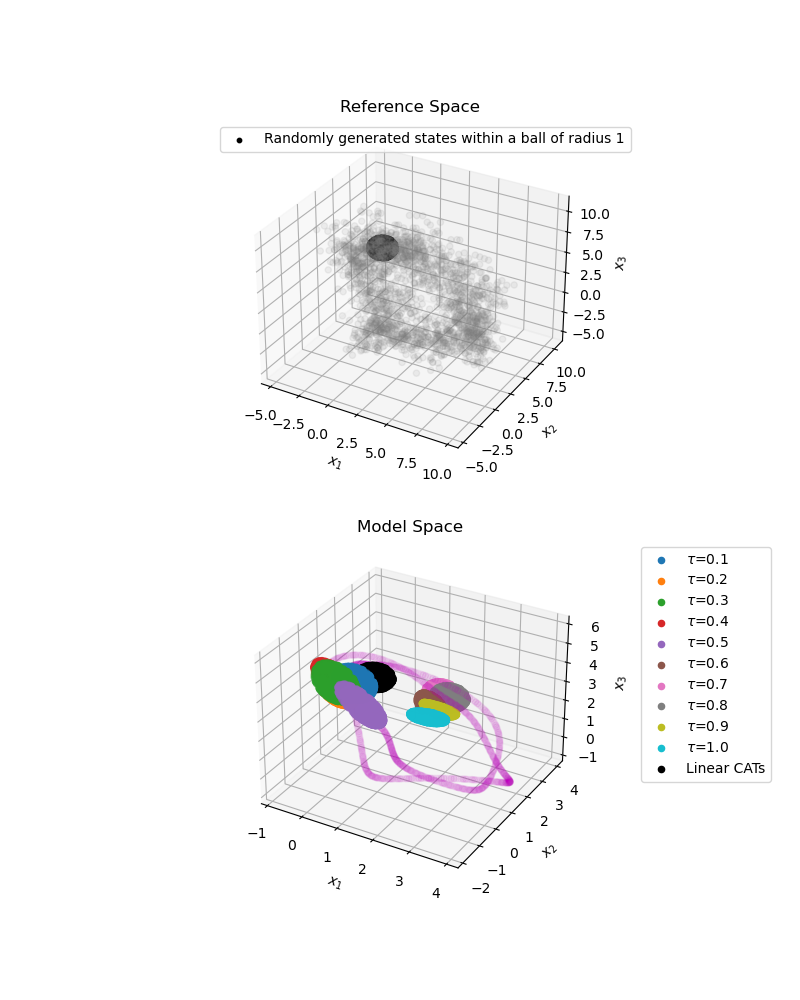

In [16]:
# Plot
fig = plt.figure(figsize=(8,10))
ax1 = fig.add_subplot(2,1,1,projection="3d")

sphere_mod_lin_cats = scaler_model.inverse_transform(sphere_mod_lin_cats_norm)
#----------------------------------

# Reference Space
ax1.scatter(states_twolevel[-2000:,0],states_twolevel[-2000:,1],
            states_twolevel[-2000:,2],color='grey',alpha=0.1)
ax1.scatter(sphere_ref[:,0],sphere_ref[:,1],sphere_ref[:,2],color='k',
            s=10,label='Randomly generated states within a ball of radius 1')
ax1.set_title('Reference Space')
#ax1.set_xlim([-4,12]); ax.set_ylim([-4,10]); ax.set_zlim([-1,10]);
ax1.set_xlabel(f'$x_1$'); ax1.set_ylabel(f'$x_2$'); ax1.set_zlabel(f'$x_3$');
#ax1.view_init(azim=-20,elev=25)
ax1.legend(bbox_to_anchor=(1.15, 1), loc='upper right')
#ax1.text(-4, -10, 20, string.ascii_uppercase[0], size=16, weight='bold')

#----------------------------------

ax2 = fig.add_subplot(2,1,2,projection="3d")
ax2.scatter(states_onelevel[-1000:,0],states_onelevel[-1000:,1],
           states_onelevel[-1000:,2],color='m',marker='o',alpha=0.05)
for i in range(len(tau_arr)):
    ax2.scatter(sphere_mod[i,:,0],sphere_mod[i,:,1],sphere_mod[i,:,2],
                label=r'$\tau$'+f'={tau_arr[i]:.1f}',s=20)
    
ax2.scatter(sphere_mod_lin_cats[:,0],sphere_mod_lin_cats[:,1],sphere_mod_lin_cats[:,2],
            label=f'Linear CATs', color='k',s=20)
ax2.set_title('Model Space')
#ax2.set_xlim([-2,4]); ax2.set_ylim([-2,4]); ax2.set_zlim([-2,4]);
ax2.set_xlabel(f'$x_1$'); ax2.set_ylabel(f'$x_2$'); ax2.set_zlabel(f'$x_3$');
ax2.legend(bbox_to_anchor=(1.55, 1), loc='best')
#ax2.view_init(azim=-15,elev=15)
#ax2.text(-2,-4,10,string.ascii_uppercase[1], size=16, weight='bold')
#plt.savefig(f'CATs_linear_nonlinear_blob_ICs_n_mtu={tau_arr[0]}-{tau_arr[-1]}.jpeg',dpi=400)
plt.show()


## Case IV: Diagnosing whether different clusters are time propagated 

In [17]:
# Consider 10 points in the Ref separated by 0.1 MTU and project them using T_rm 
# for 1, 0.9,...,0.1 MTU  

# draw a random state
index = np.random.randint(0,np.shape(testdat_ref)[0])
states_ref = testdat_ref[index:index+len(tau_arr),:]
states_ref_norm = scaler_ref.transform(states_ref)

states_mod = np.zeros((len(tau_arr),K))
states_mod_lin_cats_norm = states_ref_norm[:,:K]

for i,tau in zip(range(len(tau_arr)),np.flip(tau_arr)):
    filename = cats_path + f'L96_trm_tau={tau:.1f}.h5'
    weights = read_hdf5(filename)
    
    # project blob_ref
    temp = np.tanh(states_ref_norm[i,:].reshape(1,-1)@weights['kernel0'] + 
                   weights['bias0'].reshape(1,-1) )
    state_mod_norm = np.tanh(temp@weights['kernel1'] + weights['bias1'].reshape(1,-1) )
    states_mod[i,:] = scaler_model.inverse_transform(state_mod_norm+
                                                     states_mod_lin_cats_norm[i,:]).squeeze()
    

['add_18', 'dense_36', 'dense_36/dense_36', 'dense_36/dense_36/bias:0', 'dense_36/dense_36/kernel:0', 'dense_37', 'dense_37/dense_37', 'dense_37/dense_37/bias:0', 'dense_37/dense_37/kernel:0', 'input_28', 'tf.__operators__.getitem_9', 'top_level_model_weights']
/dense_36/dense_36/bias:0
/dense_36/dense_36/kernel:0
/dense_37/dense_37/bias:0
/dense_37/dense_37/kernel:0
['add_16', 'dense_32', 'dense_32/dense_32', 'dense_32/dense_32/bias:0', 'dense_32/dense_32/kernel:0', 'dense_33', 'dense_33/dense_33', 'dense_33/dense_33/bias:0', 'dense_33/dense_33/kernel:0', 'input_25', 'tf.__operators__.getitem_8', 'top_level_model_weights']
/dense_32/dense_32/bias:0
/dense_32/dense_32/kernel:0
/dense_33/dense_33/bias:0
/dense_33/dense_33/kernel:0
['add_14', 'dense_28', 'dense_28/dense_28', 'dense_28/dense_28/bias:0', 'dense_28/dense_28/kernel:0', 'dense_29', 'dense_29/dense_29', 'dense_29/dense_29/bias:0', 'dense_29/dense_29/kernel:0', 'input_22', 'tf.__operators__.getitem_7', 'top_level_model_weights'

<IPython.core.display.Javascript object>


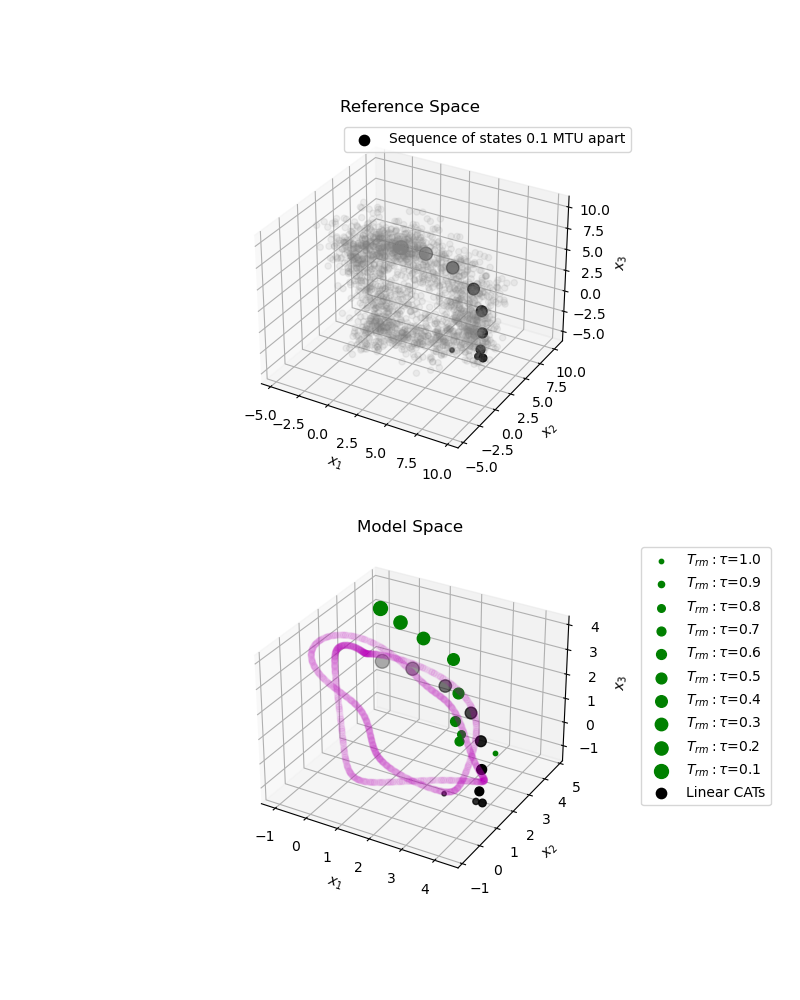

In [19]:
# Plot
fig = plt.figure(figsize=(8,10))
ax1 = fig.add_subplot(2,1,1,projection="3d")

states_mod_lin_cats = scaler_model.inverse_transform(states_mod_lin_cats_norm)
#----------------------------------

# Reference Space
ax1.scatter(states_twolevel[-2000:,0],states_twolevel[-2000:,1],
            states_twolevel[-2000:,2],color='grey',alpha=0.1)
ax1.scatter(states_ref[:,0],states_ref[:,1],states_ref[:,2],color='k',
            s=tau_arr*100,label='Sequence of states 0.1 MTU apart')
ax1.set_title('Reference Space')
#ax1.set_xlim([-4,12]); ax.set_ylim([-4,10]); ax.set_zlim([-1,10]);
ax1.set_xlabel(f'$x_1$'); ax1.set_ylabel(f'$x_2$'); ax1.set_zlabel(f'$x_3$');
#ax1.view_init(azim=-20,elev=25)
ax1.legend(bbox_to_anchor=(1.15, 1), loc='upper right')
#ax1.text(-4, -10, 20, string.ascii_uppercase[0], size=16, weight='bold')

#----------------------------------

ax2 = fig.add_subplot(2,1,2,projection="3d")
ax2.scatter(states_onelevel[-1000:,0],states_onelevel[-1000:,1],
           states_onelevel[-1000:,2],color='m',marker='o',alpha=0.05)
for i in range(len(tau_arr)):
    ax2.scatter(states_mod[i,0],states_mod[i,1],states_mod[i,2],
                label=r'$T_{rm}:\tau$'+f'={tau_arr[-1-i]:.1f}',
                s=tau_arr[i]*100,color='g')
    
ax2.scatter(states_mod_lin_cats[:,0],states_mod_lin_cats[:,1],
            states_mod_lin_cats[:,2], label=f'Linear CATs', color='k',s=tau_arr*100)
ax2.set_title('Model Space')
#ax2.set_xlim([-2,4]); ax2.set_ylim([-2,4]); ax2.set_zlim([-2,4]);
ax2.set_xlabel(f'$x_1$'); ax2.set_ylabel(f'$x_2$'); ax2.set_zlabel(f'$x_3$');
ax2.legend(bbox_to_anchor=(1.55, 1), loc='best')
#ax2.view_init(azim=-15,elev=15)
#ax2.text(-2,-4,10,string.ascii_uppercase[1], size=16, weight='bold')
#plt.savefig(f'CATs_linear_nonlinear_blob_ICs_n_mtu={tau_arr[0]}-{tau_arr[-1]}.jpeg',dpi=400)
plt.show()


### Apply the imperfect model and $T_{mr}$ for the same $\tau$

In [21]:
states_mod_F = np.zeros((len(tau_arr), K))
states_ref_F = np.zeros((len(tau_arr), K+K*J))
states_mod_lincats_F = np.zeros((len(tau_arr), K))
states_ref_lincats_F = np.zeros((len(tau_arr), K+K*J)) 

states_ref_F_true = np.zeros((len(tau_arr), K+K*J))

for i,tau in zip(range(len(tau_arr)),np.flip(tau_arr)):
    t_tau = np.linspace(0,tau,int(tau/dt)+1)
    print(t_tau)
    
    ### Advance the state forward in time
    states_mod_F[i,:] = odeint(L96_onelevel,states_mod[i,:],t_tau,args=args_onelevel)[-1,:]
    
    ### Apply T_mr
    filename = cats_path + f'L96_tmr_tau={tau:.1f}.h5'
    weights = read_hdf5(filename)
    
    # project states_mod_F
    state_mod_F_norm = scaler_model.transform(states_mod_F[i,:].reshape(1,-1))
    temp = np.tanh(state_mod_F_norm[0,:].reshape(1,-1)@weights['kernel0'] + 
                   weights['bias0'].reshape(1,-1) )
    state_ref_F_norm = np.tanh(temp@weights['kernel1'] + weights['bias1'].reshape(1,-1) )
    
    lin_approx_ss = state_mod_F_norm*slope + intercept
    state_ref_F_lin_cats_norm = np.hstack([state_mod_F_norm, np.tile(lin_approx_ss,[1,J])])
    
    states_ref_F[i,:] = scaler_ref.inverse_transform(state_ref_F_norm+
                                                     state_ref_F_lin_cats_norm).squeeze()

    ### compute the reference truth
    states_ref_F_true[i,:] = odeint(L96_twolevel,states_ref[i,:],t_tau,args=args_twolevel)[-1,:]
    
    ### compute the linear cats outputs
    states_mod_lincats_F[i,:] =  odeint(L96_onelevel,states_mod_lin_cats[i,:],
                                        t_tau,args=args_onelevel)[-1,:]
    state_mod_lincats_F_norm = scaler_model.transform(states_mod_lincats_F[i,:].reshape(1,-1))
    lin_approx_ss = state_mod_lincats_F_norm*slope + intercept
    state_ref_temp = np.hstack([state_mod_lincats_F_norm, np.tile(lin_approx_ss,[1,J])])
    states_ref_lincats_F[i,:] = scaler_ref.inverse_transform(state_ref_temp)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
['add_19', 'dense_38', 'dense_38/dense_38', 'dense_38/dense_38/bias:0', 'dense_38/dense_38/kernel:0', 'dense_39', 'dense_39/dense_39', 'dense_39/dense_39/bias:0', 'dense_39/dense_39/kernel:0', 'input_30', 'tf.__operators__.add_9', 'tf.concat_9', 'tf.math.multiply_9', 'tf.tile_9', 'top_level_model_weights']
/dense_38/dense_38/bias:0
/dense_38/dense_38/kernel:0
/dense_39/dense_39/bias:0
/dense_39/dense_39/kernel:0
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
['add_17', 'dense_34', 'dense_34/dense_34', 'dense_34/dense_34/bias:0', 'dense_34/dense_34/kernel:0', 'dense_35', 'dense_35/dense_35', 'dense_35/dense_35/bias:0', 'dense_35/dense_35/kernel:0', 'input_27', 'tf.__operators__.add_8', 'tf.concat_8', 'tf.math.multiply_8', 'tf.tile_8', 'top_level_model_weights']
/dense_34/dense_34/bias:0
/dense_34/dense_34/kernel:0
/dense_35/dense_35/bias:0
/dense_35/dense_35/kernel:0
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8]
['add_15', 'dense_30', 'dense_30/dense_30'

<IPython.core.display.Javascript object>


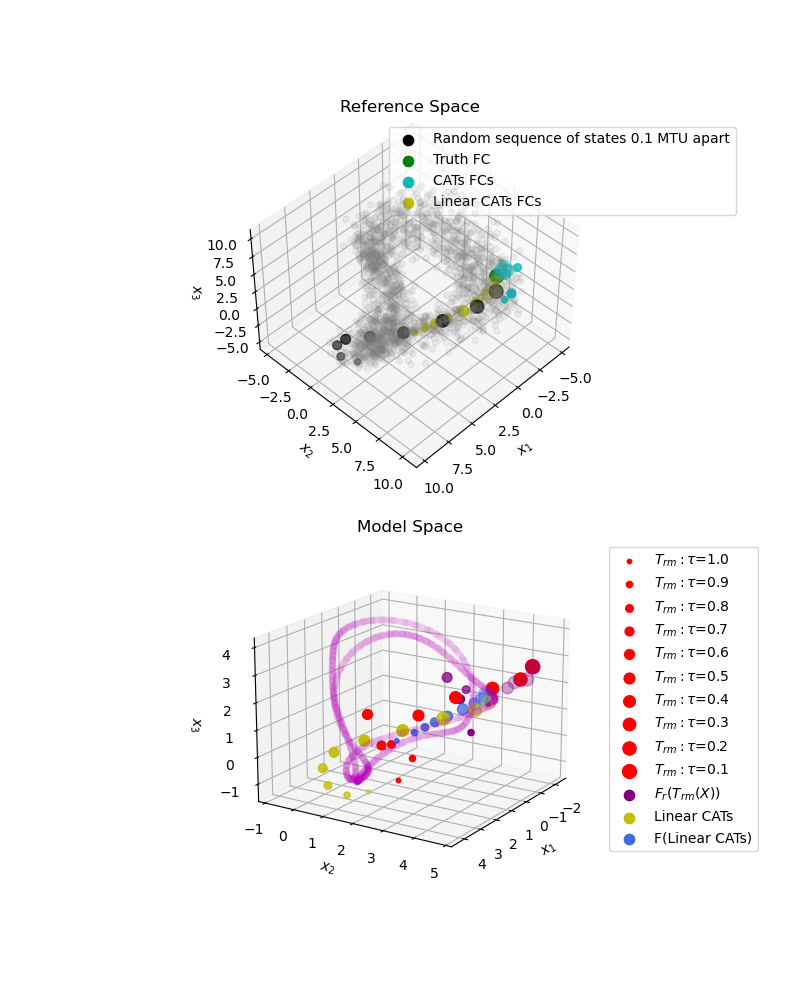

In [35]:
# Plot
fig = plt.figure(figsize=(8,10))
ax1 = fig.add_subplot(2,1,1,projection="3d")

#----------------------------------

# Reference Space
ax1.scatter(states_twolevel[-2000:,0],states_twolevel[-2000:,1],
            states_twolevel[-2000:,2],color='grey',alpha=0.1)

ax1.scatter(states_ref[:,0],states_ref[:,1],states_ref[:,2],color='k',
            s=tau_arr*100,label='Random sequence of states 0.1 MTU apart')

ax1.scatter(states_ref_F_true[:,0],states_ref_F_true[:,1],
            states_ref_F_true[:,2],color='g', s=tau_arr*100,
            label='Truth FC')

ax1.scatter(states_ref_F[:,0],states_ref_F[:,1],states_ref_F[:,2],color='c',
            s=tau_arr*100,label='CATs FCs')

ax1.scatter(states_ref_lincats_F[:,0],states_ref_lincats_F[:,1],
            states_ref_lincats_F[:,2],color='y',s=tau_arr*100,
            label='Linear CATs FCs')

ax1.set_title('Reference Space')
#ax1.set_xlim([-4,12]); ax.set_ylim([-4,10]); ax.set_zlim([-1,10]);
ax1.set_xlabel(f'$x_1$'); ax1.set_ylabel(f'$x_2$'); ax1.set_zlabel(f'$x_3$');
#ax1.view_init(azim=-20,elev=25)
ax1.legend(bbox_to_anchor=(1.45, 1), loc='upper right')
#ax1.text(-4, -10, 20, string.ascii_uppercase[0], size=16, weight='bold')

#----------------------------------

ax2 = fig.add_subplot(2,1,2,projection="3d")
ax2.scatter(states_onelevel[-1000:,0],states_onelevel[-1000:,1],
           states_onelevel[-1000:,2],color='m',marker='o',alpha=0.05)

for i in range(len(tau_arr)):
    ax2.scatter(states_mod[i,0],states_mod[i,1],states_mod[i,2],
                label=r'$T_{rm}: \tau$'+f'={tau_arr[-1-i]:.1f}',
                s=tau_arr[i]*100,color='r')

ax2.scatter(states_mod_F[:,0],states_mod_F[:,1],states_mod_F[:,2],
            label=r'$F_r(T_{rm}(X))$',
            s=tau_arr*100,color='purple')
    
ax2.scatter(states_mod_lin_cats[:,0],states_mod_lin_cats[:,1],
            states_mod_lin_cats[:,2],label=f'Linear CATs', 
            color='y',s=tau_arr*100)

ax2.scatter(states_mod_lincats_F[:,0],states_mod_lincats_F[:,1],
            states_mod_lincats_F[:,2],label=f'F(Linear CATs)', 
            color='royalblue',s=tau_arr*100)

ax2.set_title('Model Space')
#ax2.set_xlim([-2,4]); ax2.set_ylim([-2,4]); ax2.set_zlim([-2,4]);
ax2.set_xlabel(f'$x_1$'); ax2.set_ylabel(f'$x_2$'); ax2.set_zlabel(f'$x_3$');
ax2.legend(bbox_to_anchor=(1.05, 1), loc='best')
#ax2.view_init(azim=-15,elev=15)
#ax2.text(-2,-4,10,string.ascii_uppercase[1], size=16, weight='bold')
#plt.savefig(f'CATs_linear_nonlinear_blob_ICs_n_mtu={tau_arr[0]}-{tau_arr[-1]}.jpeg',dpi=400)
plt.show()

# Repeat the above analyses for $T_{mr}$

## Case I: A random blob of states in the model space and apply $T_{mr}$ from various $\tau$

<IPython.core.display.Javascript object>


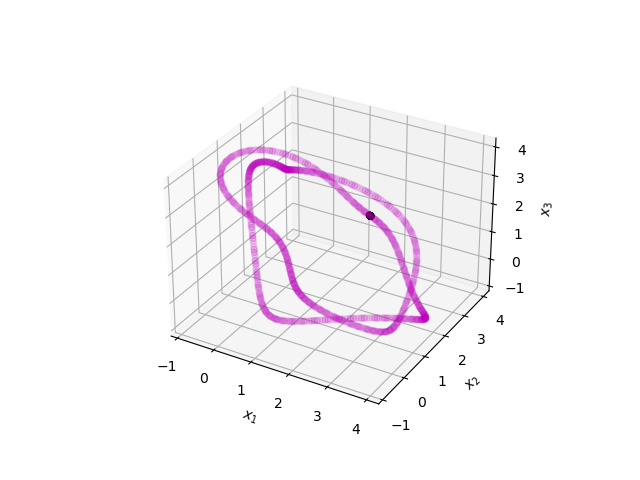

In [18]:
# number of nearest neighbours
nn = 20 

# draw a random state
index = np.random.randint(0,np.shape(testdat_mod)[0])
state_mod = testdat_mod[index,:]

# get the nearest neighbours
nn_dist = np.sqrt(np.mean((states_onelevel - state_mod)**2, axis=1))
nn_indices = np.argsort(nn_dist)[:nn]
blob_mod = states_onelevel[np.sort(nn_indices),:] # blob of points in the reference space
    
# plot
fig, ax = plt.subplots(1,1,subplot_kw=dict(projection="3d"))
ax.scatter(states_onelevel[-1000:,0],states_onelevel[-1000:,1],
           states_onelevel[-1000:,2], color='m', alpha=0.1)
ax.scatter(blob_mod[:,0],blob_mod[:,1],blob_mod[:,2],color='k')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$x_3$')
plt.show()

In [19]:
# project the blob to the reference space using T_mr trained for various taus
blob_ref = np.zeros((len(tau_arr),nn,K+J*K))
blob_mod_norm = scaler_model.transform(blob_mod)

lin_approx_ss = slope*blob_mod_norm + intercept
blob_ref_lin_cats_norm = np.hstack([blob_mod_norm, np.tile(lin_approx_ss,[1,J])])

for i,tau in zip(range(len(tau_arr)),tau_arr):
    filename = cats_path + f'L96_tmr_tau={tau:.1f}.h5'
    weights = read_hdf5(filename)
    
    # project blob_ref
    temp = np.tanh(blob_mod_norm@weights['kernel0'] + np.tile(weights['bias0'].reshape(1,-1),[nn,1]) )
    blob_ref_norm = np.tanh(temp@weights['kernel1'] + np.tile(weights['bias1'].reshape(1,-1),[nn,1]) )
    blob_ref[i,:,:] = scaler_ref.inverse_transform(blob_ref_norm+blob_ref_lin_cats_norm)

['add_1', 'dense_2', 'dense_2/dense_2', 'dense_2/dense_2/bias:0', 'dense_2/dense_2/kernel:0', 'dense_3', 'dense_3/dense_3', 'dense_3/dense_3/bias:0', 'dense_3/dense_3/kernel:0', 'input_3', 'tf.__operators__.add', 'tf.concat', 'tf.math.multiply', 'tf.tile', 'top_level_model_weights']
/dense_2/dense_2/bias:0
/dense_2/dense_2/kernel:0
/dense_3/dense_3/bias:0
/dense_3/dense_3/kernel:0
['add_3', 'dense_6', 'dense_6/dense_6', 'dense_6/dense_6/bias:0', 'dense_6/dense_6/kernel:0', 'dense_7', 'dense_7/dense_7', 'dense_7/dense_7/bias:0', 'dense_7/dense_7/kernel:0', 'input_6', 'tf.__operators__.add_1', 'tf.concat_1', 'tf.math.multiply_1', 'tf.tile_1', 'top_level_model_weights']
/dense_6/dense_6/bias:0
/dense_6/dense_6/kernel:0
/dense_7/dense_7/bias:0
/dense_7/dense_7/kernel:0
['add_5', 'dense_10', 'dense_10/dense_10', 'dense_10/dense_10/bias:0', 'dense_10/dense_10/kernel:0', 'dense_11', 'dense_11/dense_11', 'dense_11/dense_11/bias:0', 'dense_11/dense_11/kernel:0', 'input_9', 'tf.__operators__.add

<IPython.core.display.Javascript object>


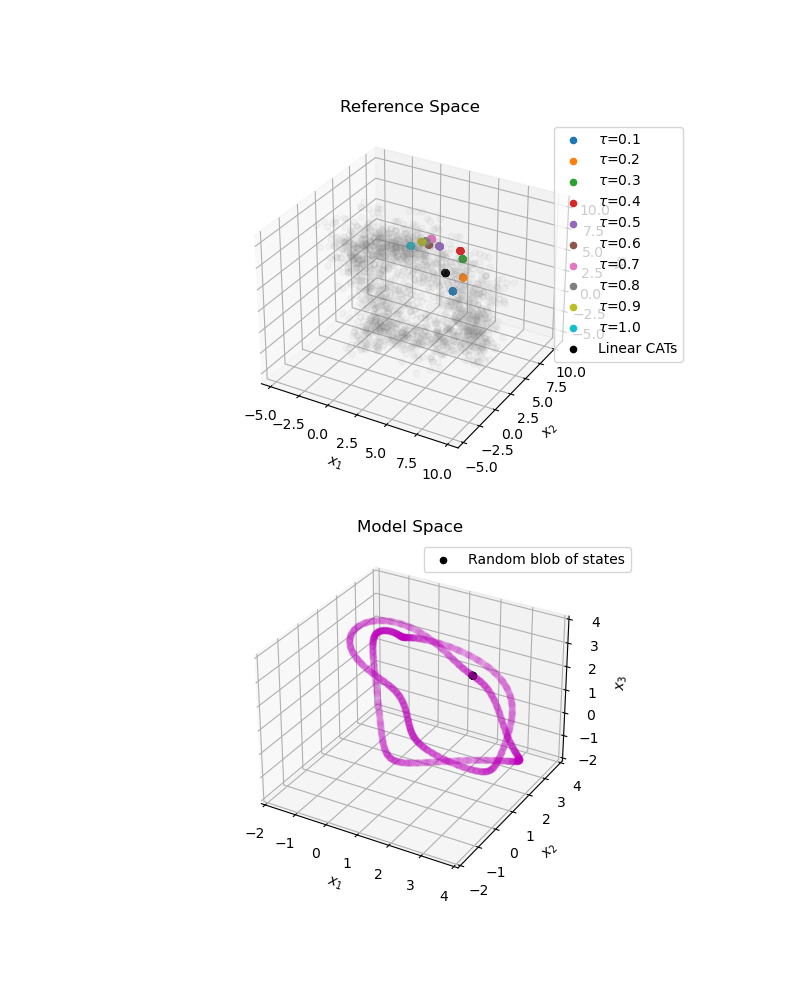

In [20]:
# Plot
import string
fig = plt.figure(figsize=(8,10))
ax1 = fig.add_subplot(2,1,1,projection="3d")

blob_ref_lin_cats = scaler_ref.inverse_transform(blob_ref_lin_cats_norm)
#----------------------------------
# Reference Space

ax1.scatter(states_twolevel[-2000:,0],states_twolevel[-2000:,1],
           states_twolevel[-2000:,2],color='grey',marker='o',alpha=0.05)
for i in range(10):
    ax1.scatter(blob_ref[i,:,0],blob_ref[i,:,1],blob_ref[i,:,2],
                label=r'$\tau$'+f'={tau_arr[i]:.1f}')
    
ax1.scatter(blob_ref_lin_cats[:,0],blob_ref_lin_cats[:,1],blob_ref_lin_cats[:,2],
            label=f'Linear CATs', color='k')
ax1.set_title('Reference Space')
#ax1.set_xlim([-4,12]); ax.set_ylim([-4,10]); ax.set_zlim([-1,10]);
ax1.set_xlabel(f'$x_1$'); ax2.set_ylabel(f'$x_2$'); ax2.set_zlabel(f'$x_3$');
ax1.legend(bbox_to_anchor=(1.3, 1), loc='best')
#ax1.view_init(azim=-15,elev=15)
#ax1.text(-2,-4,10,string.ascii_uppercase[1], size=16, weight='bold')

#----------------------------------
# Model Space
ax2 = fig.add_subplot(2,1,2,projection="3d")
ax2.scatter(states_onelevel[-1000:,0],states_onelevel[-1000:,1],
            states_onelevel[-1000:,2], color='m', alpha=0.1)
ax2.scatter(blob_mod[:,0],blob_mod[:,1],blob_mod[:,2],color='k',
            label='Random blob of states')
ax2.set_title('Model Space')
ax2.set_xlim([-2,4]); ax2.set_ylim([-2,4]); ax2.set_zlim([-2,4]);
ax2.set_xlabel(f'$x_1$'); ax1.set_ylabel(f'$x_2$'); ax1.set_zlabel(f'$x_3$');
#ax2.view_init(azim=-20,elev=25)
ax2.legend(bbox_to_anchor=(1.15, 1), loc='upper right')
#ax2.text(-4, -10, 20, string.ascii_uppercase[0], size=16, weight='bold')

#plt.savefig(f'CATs_linear_nonlinear_blob_ICs_n_mtu={tau_arr[0]}-{tau_arr[-1]}.jpeg',dpi=400)
plt.show()

## Case II: For the random state only

In [21]:
state_ref = np.zeros((len(tau_arr),K+K*J))
state_mod_norm = scaler_model.transform(np.reshape(state_mod,[1,-1]))

lin_approx_ss = slope*state_mod_norm + intercept
state_ref_lin_cats_norm = np.hstack([state_mod_norm, np.tile(lin_approx_ss,[1,J])])

for i,tau in zip(range(len(tau_arr)),tau_arr):
    filename = cats_path + f'L96_tmr_tau={tau:.1f}.h5'
    weights = read_hdf5(filename)
    
    # project state_ref
    temp = np.tanh(state_mod_norm@weights['kernel0'] + weights['bias0'].reshape(1,-1) )
    state_ref_norm = np.tanh(temp@weights['kernel1'] + weights['bias1'].reshape(1,-1) )
    state_ref[i,:] = np.squeeze(scaler_ref.inverse_transform(state_ref_norm+state_ref_lin_cats_norm))

['add_1', 'dense_2', 'dense_2/dense_2', 'dense_2/dense_2/bias:0', 'dense_2/dense_2/kernel:0', 'dense_3', 'dense_3/dense_3', 'dense_3/dense_3/bias:0', 'dense_3/dense_3/kernel:0', 'input_3', 'tf.__operators__.add', 'tf.concat', 'tf.math.multiply', 'tf.tile', 'top_level_model_weights']
/dense_2/dense_2/bias:0
/dense_2/dense_2/kernel:0
/dense_3/dense_3/bias:0
/dense_3/dense_3/kernel:0
['add_3', 'dense_6', 'dense_6/dense_6', 'dense_6/dense_6/bias:0', 'dense_6/dense_6/kernel:0', 'dense_7', 'dense_7/dense_7', 'dense_7/dense_7/bias:0', 'dense_7/dense_7/kernel:0', 'input_6', 'tf.__operators__.add_1', 'tf.concat_1', 'tf.math.multiply_1', 'tf.tile_1', 'top_level_model_weights']
/dense_6/dense_6/bias:0
/dense_6/dense_6/kernel:0
/dense_7/dense_7/bias:0
/dense_7/dense_7/kernel:0
['add_5', 'dense_10', 'dense_10/dense_10', 'dense_10/dense_10/bias:0', 'dense_10/dense_10/kernel:0', 'dense_11', 'dense_11/dense_11', 'dense_11/dense_11/bias:0', 'dense_11/dense_11/kernel:0', 'input_9', 'tf.__operators__.add

<IPython.core.display.Javascript object>


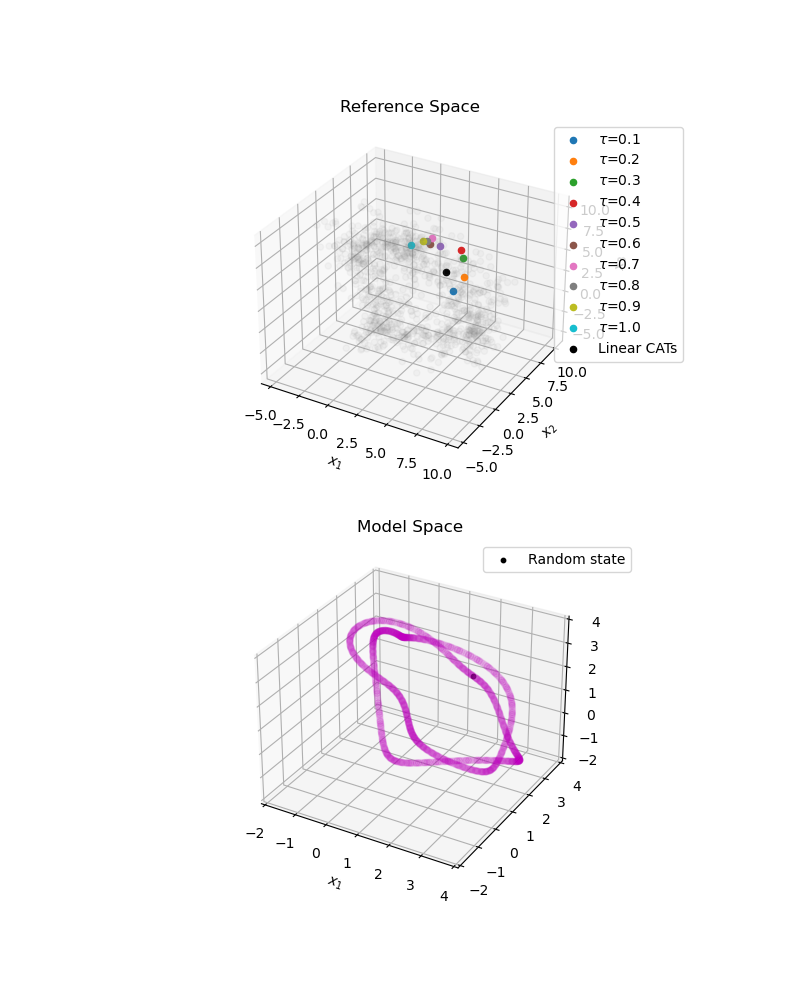

In [22]:
# Plot
import string
fig = plt.figure(figsize=(8,10))
ax1 = fig.add_subplot(2,1,1,projection="3d")

state_ref_lin_cats = scaler_ref.inverse_transform(state_ref_lin_cats_norm)
#----------------------------------
# Reference Space
ax1.scatter(states_twolevel[-1000:,0],states_twolevel[-1000:,1],
           states_twolevel[-1000:,2],color='grey',marker='o',alpha=0.05)
for i in range(len(tau_arr)):
    ax1.scatter(state_ref[i,0],state_ref[i,1],state_ref[i,2],
                label=r'$\tau$'+f'={tau_arr[i]:.1f}')
    
ax1.scatter(state_ref_lin_cats[:,0],state_ref_lin_cats[:,1],state_ref_lin_cats[:,2],
            label=f'Linear CATs', color='k')
ax1.set_title('Reference Space')
#ax1.set_xlim([-4,12]); ax.set_ylim([-4,10]); ax.set_zlim([-1,10]);
ax1.set_xlabel(f'$x_1$'); ax2.set_ylabel(f'$x_2$'); ax2.set_zlabel(f'$x_3$');
ax1.legend(bbox_to_anchor=(1.3, 1), loc='best')
#ax1.view_init(azim=-15,elev=15)
#ax1.text(-2,-4,10,string.ascii_uppercase[1], size=16, weight='bold')

#----------------------------------
# Model Space
ax2 = fig.add_subplot(2,1,2,projection="3d")
ax2.scatter(states_onelevel[-1000:,0],states_onelevel[-1000:,1],
            states_onelevel[-1000:,2], color='m', alpha=0.1)
ax2.scatter(state_mod[0],state_mod[1],state_mod[2],color='k',
            label='Random state',s=10)
ax2.set_title('Model Space')
ax2.set_xlim([-2,4]); ax2.set_ylim([-2,4]); ax2.set_zlim([-2,4]);
ax2.set_xlabel(f'$x_1$'); ax1.set_ylabel(f'$x_2$'); ax1.set_zlabel(f'$x_3$');
#ax2.view_init(azim=-20,elev=25)
ax2.legend(bbox_to_anchor=(1.15, 1), loc='upper right')
#ax2.text(-4, -10, 20, string.ascii_uppercase[0], size=16, weight='bold')

#plt.savefig(f'CATs_linear_nonlinear_blob_ICs_n_mtu={tau_arr[0]}-{tau_arr[-1]}.jpeg',dpi=400)
plt.show()

## Case III: for states within a ball of radius 1

<IPython.core.display.Javascript object>


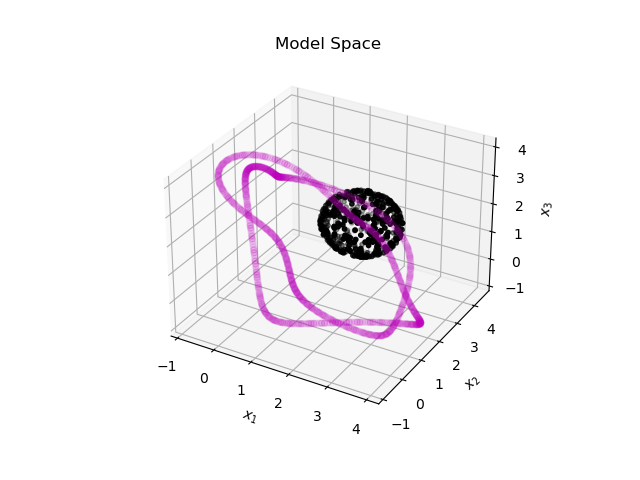

In [23]:
# Using random perturbations 
r = 1; nrand = 500; ndim = 3
rand_pert = np.random.randn(nrand,ndim)
norm = np.sqrt(np.sum(np.square(rand_pert),axis=1)).reshape(-1,1)
if (ndim<K):
    rand_pert = np.hstack([r*rand_pert/np.tile(norm,[1,ndim]), np.zeros((nrand,K-ndim))])
else:
    rand_pert = r*rand_pert/np.tile(norm,[1,ndim])
sphere_mod = np.tile(state_mod,[nrand,1])+rand_pert

# plot
fig, ax = plt.subplots(1,1,subplot_kw=dict(projection="3d"))
ax.scatter(states_onelevel[-1000:,0],states_onelevel[-1000:,1],
              states_onelevel[-1000:,2], color='m', alpha=0.1)
ax.scatter(sphere_mod[:,0],sphere_mod[:,1],sphere_mod[:,2],color='k',s=10)
ax.set_title('Model Space')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$x_3$')
plt.show()

In [24]:
sphere_ref = np.zeros((len(tau_arr),nrand,K+J*K))
sphere_mod_norm = scaler_model.transform(sphere_mod)

lin_approx_ss = slope*sphere_mod_norm + intercept
sphere_ref_lin_cats_norm = np.hstack([sphere_mod_norm, np.tile(lin_approx_ss,[1,J])])

for i,tau in zip(range(len(tau_arr)),tau_arr):
    filename = cats_path + f'L96_tmr_tau={tau:.1f}.h5'
    weights = read_hdf5(filename)
    
    # project blob_ref
    temp = np.tanh(sphere_mod_norm@weights['kernel0'] + np.tile(weights['bias0'].reshape(1,-1),[nrand,1]) )
    sphere_ref_norm = np.tanh(temp@weights['kernel1'] + np.tile(weights['bias1'].reshape(1,-1),[nrand,1]) )
    sphere_ref[i,:,:] = scaler_ref.inverse_transform(sphere_ref_norm + sphere_ref_lin_cats_norm)

['add_1', 'dense_2', 'dense_2/dense_2', 'dense_2/dense_2/bias:0', 'dense_2/dense_2/kernel:0', 'dense_3', 'dense_3/dense_3', 'dense_3/dense_3/bias:0', 'dense_3/dense_3/kernel:0', 'input_3', 'tf.__operators__.add', 'tf.concat', 'tf.math.multiply', 'tf.tile', 'top_level_model_weights']
/dense_2/dense_2/bias:0
/dense_2/dense_2/kernel:0
/dense_3/dense_3/bias:0
/dense_3/dense_3/kernel:0
['add_3', 'dense_6', 'dense_6/dense_6', 'dense_6/dense_6/bias:0', 'dense_6/dense_6/kernel:0', 'dense_7', 'dense_7/dense_7', 'dense_7/dense_7/bias:0', 'dense_7/dense_7/kernel:0', 'input_6', 'tf.__operators__.add_1', 'tf.concat_1', 'tf.math.multiply_1', 'tf.tile_1', 'top_level_model_weights']
/dense_6/dense_6/bias:0
/dense_6/dense_6/kernel:0
/dense_7/dense_7/bias:0
/dense_7/dense_7/kernel:0
['add_5', 'dense_10', 'dense_10/dense_10', 'dense_10/dense_10/bias:0', 'dense_10/dense_10/kernel:0', 'dense_11', 'dense_11/dense_11', 'dense_11/dense_11/bias:0', 'dense_11/dense_11/kernel:0', 'input_9', 'tf.__operators__.add

<IPython.core.display.Javascript object>


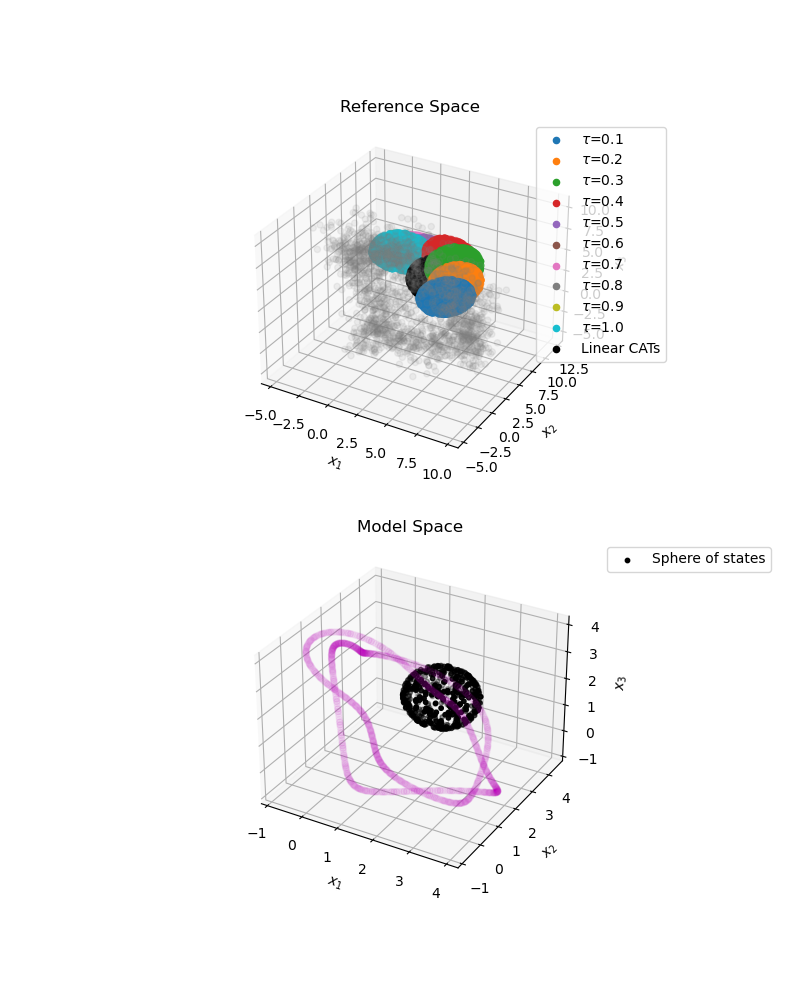

In [25]:
# Plot
fig = plt.figure(figsize=(8,10))
ax1 = fig.add_subplot(2,1,1,projection="3d")

#----------------------------------
sphere_ref_lin_cats = scaler_ref.inverse_transform(sphere_ref_lin_cats_norm)

# Reference Space
ax1.scatter(states_twolevel[-2000:,0],states_twolevel[-2000:,1],
            states_twolevel[-2000:,2],color='grey',alpha=0.1)
for i in range(len(tau_arr)):
    ax1.scatter(sphere_ref[i,:,0],sphere_ref[i,:,1],sphere_ref[i,:,2],
                label=r'$\tau$'+f'={tau_arr[i]:.1f}',s=20)
    
ax1.scatter(sphere_ref_lin_cats[:,0],sphere_ref_lin_cats[:,1],sphere_ref_lin_cats[:,2],
            label=f'Linear CATs', color='k',s=20)
ax1.set_title('Reference Space')
#ax1.set_xlim([-4,12]); ax.set_ylim([-4,10]); ax.set_zlim([-1,10]);
ax1.set_xlabel(f'$x_1$'); ax1.set_ylabel(f'$x_2$'); ax1.set_zlabel(f'$x_3$');
#ax1.view_init(azim=-20,elev=25)
ax1.legend(bbox_to_anchor=(1.25, 1), loc='upper right')
#ax1.text(-4, -10, 20, string.ascii_uppercase[0], size=16, weight='bold')

#----------------------------------

ax2 = fig.add_subplot(2,1,2,projection="3d")
ax2.scatter(states_onelevel[-1000:,0],states_onelevel[-1000:,1],
           states_onelevel[-1000:,2],color='m',marker='o',alpha=0.05)
ax2.scatter(sphere_mod[:,0],sphere_mod[:,1],sphere_mod[:,2],color='k',s=10,label='Sphere of states')
ax2.set_title('Model Space')
#ax2.set_xlim([-2,4]); ax2.set_ylim([-2,4]); ax2.set_zlim([-2,4]);
ax2.set_xlabel(f'$x_1$'); ax2.set_ylabel(f'$x_2$'); ax2.set_zlabel(f'$x_3$');
ax2.legend(bbox_to_anchor=(1.55, 1), loc='best')
#ax2.view_init(azim=-15,elev=15)
#ax2.text(-2,-4,10,string.ascii_uppercase[1], size=16, weight='bold')
#plt.savefig(f'CATs_linear_nonlinear_blob_ICs_n_mtu={tau_arr[0]}-{tau_arr[-1]}.jpeg',dpi=400)
plt.show()


## Case IV: ICs separated by $\tau$ = 0.1 MTU

In [33]:
# Consider 10 points in the Ref separated by 0.1 MTU and project them using T_mr for 1, 0.9,...,0.1 MTU  
# draw a random state
index = np.random.randint(0,np.shape(testdat_mod)[0])
states_mod = testdat_mod[index:index+len(tau_arr),:]
states_mod_norm = scaler_model.transform(states_mod)

lin_approx_ss = slope*states_mod_norm + intercept
states_ref_lin_cats_norm = np.hstack([states_mod_norm, np.tile(lin_approx_ss,[1,J])])

states_ref_cross = np.zeros((len(tau_arr),K*J+K))
#states_ref_order = np.zeros((len(tau_arr),K*J+K))

# compute states with T_mr from 1-tau
for i,tau in zip(range(len(tau_arr)),np.flip(tau_arr)):
    filename = cats_path + f'L96_tmr_tau={tau:.1f}.h5'
    print(filename)
    weights = read_hdf5(filename)
    
    # project blob_ref
    temp = np.tanh(states_mod_norm[i,:].reshape(1,-1)@weights['kernel0'] + 
                   weights['bias0'].reshape(1,-1) )
    state_ref_norm = np.tanh(temp@weights['kernel1'] + weights['bias1'].reshape(1,-1) )
    states_ref_cross[i,:] = scaler_ref.inverse_transform(state_ref_norm+
                                                         states_ref_lin_cats_norm[i,:]).squeeze()

# compute states with T_mr from tau 
#for i,tau in zip(range(len(tau_arr)),tau_arr):
#    filename = cats_path + f'L96_tmr_tau={tau:.1f}.h5'
#    print(filename)
#    weights = read_hdf5(filename)
#    
#    # project blob_ref
#    temp = np.tanh(states_mod_norm[i,:].reshape(1,-1)@weights['kernel0'] + 
#                   weights['bias0'].reshape(1,-1) )
#    state_ref_norm = np.tanh(temp@weights['kernel1'] + weights['bias1'].reshape(1,-1) )
#    states_ref_order[i,:] = scaler_ref.inverse_transform(state_ref_norm+
#                                                         states_ref_lin_cats_norm[i,:]).squeeze()

./trained_cats/L96_tmr_tau=1.0.h5
['add_19', 'dense_38', 'dense_38/dense_38', 'dense_38/dense_38/bias:0', 'dense_38/dense_38/kernel:0', 'dense_39', 'dense_39/dense_39', 'dense_39/dense_39/bias:0', 'dense_39/dense_39/kernel:0', 'input_30', 'tf.__operators__.add_9', 'tf.concat_9', 'tf.math.multiply_9', 'tf.tile_9', 'top_level_model_weights']
/dense_38/dense_38/bias:0
/dense_38/dense_38/kernel:0
/dense_39/dense_39/bias:0
/dense_39/dense_39/kernel:0
./trained_cats/L96_tmr_tau=0.9.h5
['add_17', 'dense_34', 'dense_34/dense_34', 'dense_34/dense_34/bias:0', 'dense_34/dense_34/kernel:0', 'dense_35', 'dense_35/dense_35', 'dense_35/dense_35/bias:0', 'dense_35/dense_35/kernel:0', 'input_27', 'tf.__operators__.add_8', 'tf.concat_8', 'tf.math.multiply_8', 'tf.tile_8', 'top_level_model_weights']
/dense_34/dense_34/bias:0
/dense_34/dense_34/kernel:0
/dense_35/dense_35/bias:0
/dense_35/dense_35/kernel:0
./trained_cats/L96_tmr_tau=0.8.h5
['add_15', 'dense_30', 'dense_30/dense_30', 'dense_30/dense_30/bia

<IPython.core.display.Javascript object>


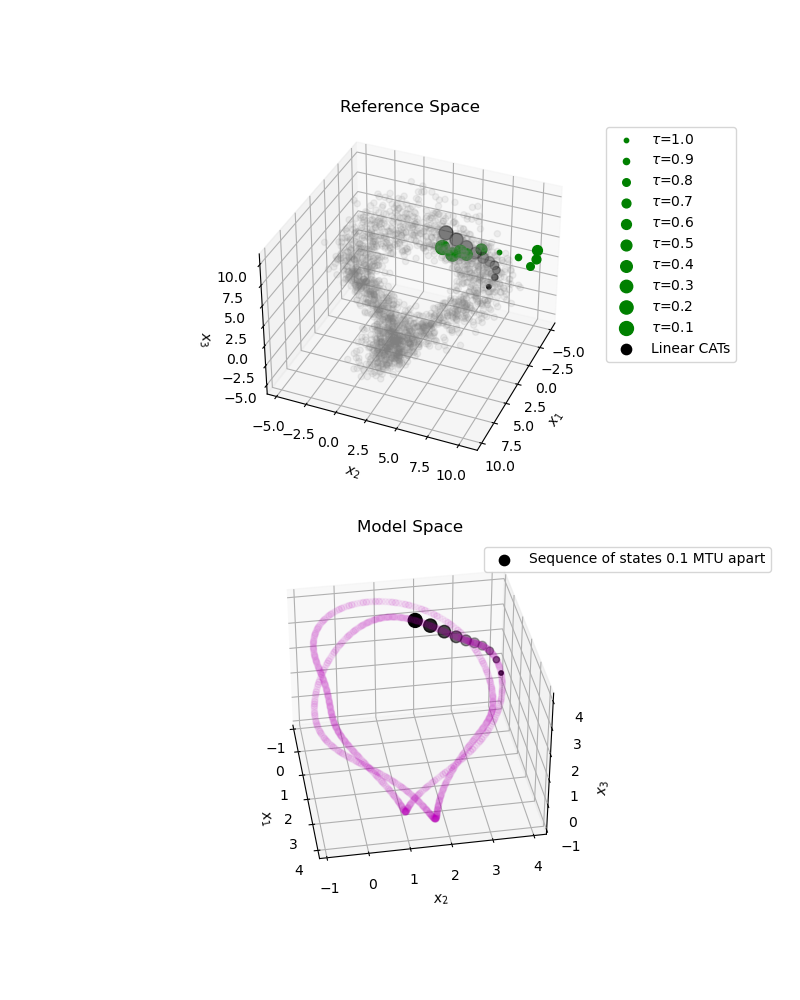

In [34]:
# Plot
fig = plt.figure(figsize=(8,10))
ax1 = fig.add_subplot(2,1,1,projection="3d")

states_ref_lin_cats = scaler_ref.inverse_transform(states_ref_lin_cats_norm)
#----------------------------------

# Reference Space
ax1.scatter(states_twolevel[-2000:,0],states_twolevel[-2000:,1],
            states_twolevel[-2000:,2],color='grey',alpha=0.1)
for i in range(len(tau_arr)):
    ax1.scatter(states_ref_cross[i,0],states_ref_cross[i,1],states_ref_cross[i,2],
                label=r'$\tau$'+f'={tau_arr[-1-i]:.1f}',s=tau_arr[i]*100,color='g')
    #ax1.scatter(states_ref_order[i,0],states_ref_order[i,1],states_ref_order[i,2],
    #            label=r'$\tau$'+f'={tau_arr[i]:.1f}',s=tau_arr[i]*100,color='r')
    
ax1.scatter(states_ref_lin_cats[:,0],states_ref_lin_cats[:,1],states_ref_lin_cats[:,2],
            label=f'Linear CATs', color='k',s=tau_arr*100)

ax1.set_title('Reference Space')
#ax1.set_xlim([-4,12]); ax.set_ylim([-4,10]); ax.set_zlim([-1,10]);
ax1.set_xlabel(f'$x_1$'); ax1.set_ylabel(f'$x_2$'); ax1.set_zlabel(f'$x_3$');
#ax1.view_init(azim=-20,elev=25)
ax1.legend(bbox_to_anchor=(1.45, 1), loc='upper right')
#ax1.text(-4, -10, 20, string.ascii_uppercase[0], size=16, weight='bold')

#----------------------------------

ax2 = fig.add_subplot(2,1,2,projection="3d")
ax2.scatter(states_onelevel[-1000:,0],states_onelevel[-1000:,1],
           states_onelevel[-1000:,2],color='m',marker='o',alpha=0.05)
ax2.scatter(states_mod[:,0],states_mod[:,1],states_mod[:,2],color='k',
            s=tau_arr*100,label='Random sequence of states 0.1 MTU apart')
ax2.set_title('Model Space')
#ax2.set_xlim([-2,4]); ax2.set_ylim([-2,4]); ax2.set_zlim([-2,4]);
ax2.set_xlabel(f'$x_1$'); ax2.set_ylabel(f'$x_2$'); ax2.set_zlabel(f'$x_3$');
ax2.legend(bbox_to_anchor=(1.55, 1), loc='best')
#ax2.view_init(azim=-15,elev=15)
#ax2.text(-2,-4,10,string.ascii_uppercase[1], size=16, weight='bold')
#plt.savefig(f'CATs_linear_nonlinear_blob_ICs_n_mtu={tau_arr[0]}-{tau_arr[-1]}.jpeg',dpi=400)
plt.show()

### Apply the imperfect model and $T_{rm}$ operator to $T_{mr}$ transformed states for the same $\tau$

In [52]:
states_ref_F = np.zeros((len(tau_arr), K+K*J))
states_mod_F = np.zeros((len(tau_arr), K))
states_mod_F_true = np.zeros((len(tau_arr), K))

for i,tau in zip(range(len(tau_arr)),np.flip(tau_arr)):
    t_tau = np.linspace(0,tau,int(tau/dt)+1)
    print(t_tau)
    
    ### Advance the state forward in time
    states_ref_F[i,:] = odeint(L96_twolevel,states_ref_cross[i,:],t_tau,args=args_twolevel)[-1,:]
    
    ### Apply T_rm
    filename = cats_path + f'L96_trm_tau={tau:.1f}.h5'
    weights = read_hdf5(filename)
    
    # project states_ref_F
    state_ref_F_norm = scaler_ref.transform(states_ref_F[i,:].reshape(1,-1))
    print(state_ref_F_norm.shape)
    temp = np.tanh(state_ref_F_norm[0,:].reshape(1,-1)@weights['kernel0'] + 
                   weights['bias0'].reshape(1,-1) )
    state_mod_F_norm = np.tanh(temp@weights['kernel1'] + weights['bias1'].reshape(1,-1) )
    states_mod_F[i,:] = scaler_model.inverse_transform(state_mod_F_norm+
                                                       state_ref_F_norm[0,:K]).squeeze()

    # compute the reference truth
    states_mod_F_true[i,:] = odeint(L96_onelevel,states_mod[i,:],t_tau,args=args_onelevel)[-1,:]

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
['add_18', 'dense_36', 'dense_36/dense_36', 'dense_36/dense_36/bias:0', 'dense_36/dense_36/kernel:0', 'dense_37', 'dense_37/dense_37', 'dense_37/dense_37/bias:0', 'dense_37/dense_37/kernel:0', 'input_28', 'tf.__operators__.getitem_9', 'top_level_model_weights']
/dense_36/dense_36/bias:0
/dense_36/dense_36/kernel:0
/dense_37/dense_37/bias:0
/dense_37/dense_37/kernel:0
(1, 40)
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
['add_16', 'dense_32', 'dense_32/dense_32', 'dense_32/dense_32/bias:0', 'dense_32/dense_32/kernel:0', 'dense_33', 'dense_33/dense_33', 'dense_33/dense_33/bias:0', 'dense_33/dense_33/kernel:0', 'input_25', 'tf.__operators__.getitem_8', 'top_level_model_weights']
/dense_32/dense_32/bias:0
/dense_32/dense_32/kernel:0
/dense_33/dense_33/bias:0
/dense_33/dense_33/kernel:0
(1, 40)
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8]
['add_14', 'dense_28', 'dense_28/dense_28', 'dense_28/dense_28/bias:0', 'dense_28/dense_28/kernel:0', 'dense_29', 'den

<IPython.core.display.Javascript object>


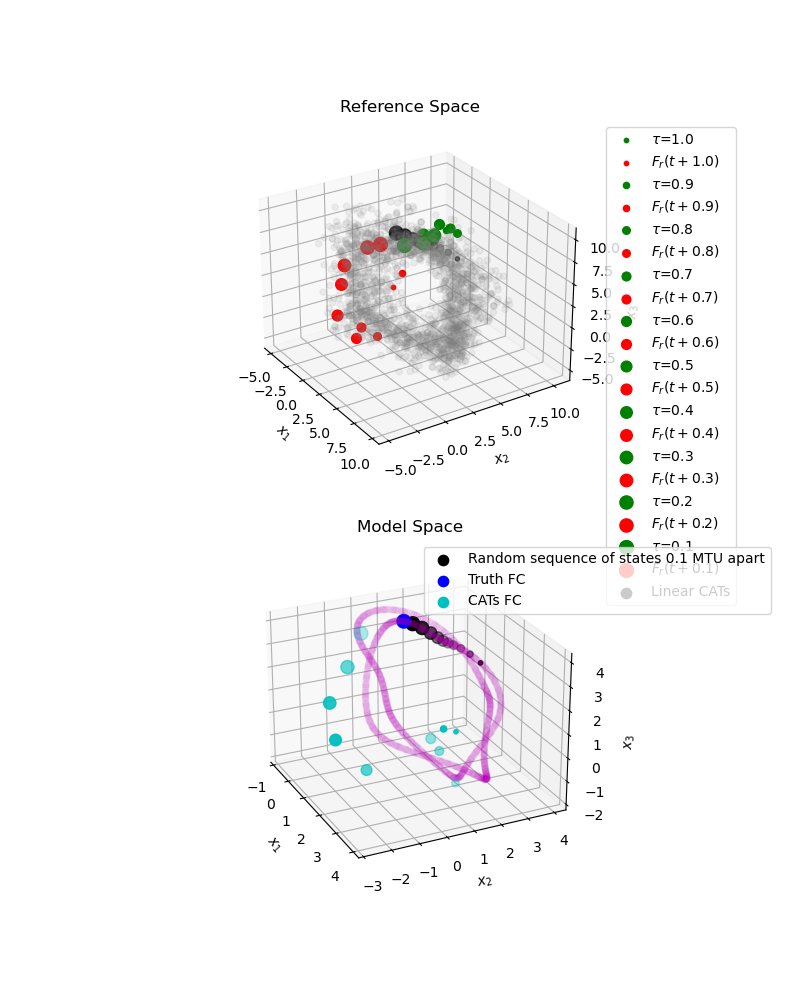

In [54]:
# Plot
fig = plt.figure(figsize=(8,10))
ax1 = fig.add_subplot(2,1,1,projection="3d")

states_ref_lin_cats = scaler_ref.inverse_transform(states_ref_lin_cats_norm)
#----------------------------------

# Reference Space
ax1.scatter(states_twolevel[-2000:,0],states_twolevel[-2000:,1],
            states_twolevel[-2000:,2],color='grey',alpha=0.1)
for i in range(len(tau_arr)):
    ax1.scatter(states_ref_cross[i,0],states_ref_cross[i,1],states_ref_cross[i,2],
                label=r'$\tau$'+f'={tau_arr[-1-i]:.1f}',s=tau_arr[i]*100,color='g')
    ax1.scatter(states_ref_F[i,0],states_ref_F[i,1],states_ref_F[i,2],
                label=r'$F_r(t+$' + f'{tau_arr[-1-i]:.1f}' + ')',
                s=tau_arr[i]*100,color='r')
    
ax1.scatter(states_ref_lin_cats[:,0],states_ref_lin_cats[:,1],states_ref_lin_cats[:,2],
            label=f'Linear CATs', color='k',s=tau_arr*100)

ax1.set_title('Reference Space')
#ax1.set_xlim([-4,12]); ax.set_ylim([-4,10]); ax.set_zlim([-1,10]);
ax1.set_xlabel(f'$x_1$'); ax1.set_ylabel(f'$x_2$'); ax1.set_zlabel(f'$x_3$');
#ax1.view_init(azim=-20,elev=25)
ax1.legend(bbox_to_anchor=(1.45, 1), loc='upper right')
#ax1.text(-4, -10, 20, string.ascii_uppercase[0], size=16, weight='bold')

#----------------------------------

ax2 = fig.add_subplot(2,1,2,projection="3d")
ax2.scatter(states_onelevel[-1000:,0],states_onelevel[-1000:,1],
           states_onelevel[-1000:,2],color='m',marker='o',alpha=0.05)
ax2.scatter(states_mod[:,0],states_mod[:,1],states_mod[:,2],color='k',
            s=tau_arr*100,label='Random sequence of states 0.1 MTU apart')
ax2.scatter(states_mod_F_true[:,0],states_mod_F_true[:,1],states_mod_F_true[:,2],color='b',
            s=tau_arr*100,label='Truth FC')
ax2.scatter(states_mod_F[:,0],states_mod_F[:,1],states_mod_F[:,2],color='c',
            s=tau_arr*100,label='CATs FC')
ax2.set_title('Model Space')
#ax2.set_xlim([-2,4]); ax2.set_ylim([-2,4]); ax2.set_zlim([-2,4]);
ax2.set_xlabel(f'$x_1$'); ax2.set_ylabel(f'$x_2$'); ax2.set_zlabel(f'$x_3$');
ax2.legend(bbox_to_anchor=(1.55, 1), loc='best')
#ax2.view_init(azim=-15,elev=15)
#ax2.text(-2,-4,10,string.ascii_uppercase[1], size=16, weight='bold')
#plt.savefig(f'CATs_linear_nonlinear_blob_ICs_n_mtu={tau_arr[0]}-{tau_arr[-1]}.jpeg',dpi=400)
plt.show()